### Notebook used to test the 3D contrucstion based on feature detection and depth stimation

To test it:
- Obtain Features of two frames
- Match the feature
- Stimate depth
- stimate pose

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

In [3]:

DATASET_PATH = "final_project_data/originals/"
DATASET_NOT_REC = "final_project_data/"

## Get the images
left_images = glob.glob(DATASET_PATH + "/seq_1/image_02/data/*.png")
right_images = glob.glob(DATASET_PATH + "/seq_1/image_03/data/*.png")
left_images.sort()
right_images.sort()

left_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_02/data/*.png")
right_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_03/data/*.png")

maxTimeStep = len(right_images)
print(maxTimeStep)

old_disparity = new_disparity = None

145


In [4]:
# Create a stereoBM object and tweak the parameters to obtain the best disparity map

def nothing(x):
    pass

def blockMatchingMap(left_img, right_img):
    """Function using the block matching algorithm to compute the disparity map

    Args:
        left_img (ndarray): color image of the left camera
        right_img (ndarray): color image of the right camera

    Returns:
        stereo: the block matching object
        disparity: the disparity map
    """    
    
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    ###### Default values ######
    blockSize = 13          # odd number
    numDisparities = 7  # multiple of 16
    preFilterSize = 5
    preFilterCap = 3
    textureThreshold = 10
    uniquenessRatio = 1

    # affect the noise
    speckleRange = 50
    speckleWindowSize = 54

    disp12MaxDiff = 1
    minDisparity = 3
    ###################
    
    cv2.createTrackbar('minDisparity','disp',minDisparity,25,nothing)
    cv2.createTrackbar('numDisparities','disp',numDisparities,17,nothing)
    cv2.createTrackbar('blockSize','disp',blockSize,50,nothing)
    # cv2.createTrackbar('preFilterType','disp',1,1,nothing)
    cv2.createTrackbar('preFilterSize','disp',preFilterSize,25,nothing)
    cv2.createTrackbar('preFilterCap','disp',preFilterCap,62,nothing)
    cv2.createTrackbar('textureThreshold','disp',textureThreshold,100,nothing)
    cv2.createTrackbar('disp12MaxDiff','disp',disp12MaxDiff,25,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',uniquenessRatio,100,nothing)
    cv2.createTrackbar('speckleRange','disp',speckleRange,100,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',speckleWindowSize,100,nothing)
    
    # Creating an object of StereoBM algorithm
    stereo = cv2.StereoBM_create()

    # convert images to grayscale for template matching
    left_image = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
        preFilterCap = 1 if preFilterCap == 0 else preFilterCap
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5

        # preFilterType = cv2.getTrackbarPos('preFilterType','disp')
        preFilterSize = cv2.getTrackbarPos('preFilterSize','disp')*2 + 5
        textureThreshold = cv2.getTrackbarPos('textureThreshold','disp')
        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        stereo.setNumDisparities(numDisparities)
        stereo.setBlockSize(blockSize)
        stereo.setPreFilterType(1)
        stereo.setPreFilterSize(preFilterSize)
        stereo.setPreFilterCap(preFilterCap)
        stereo.setTextureThreshold(textureThreshold)
        stereo.setUniquenessRatio(uniquenessRatio)
        stereo.setSpeckleRange(speckleRange)
        stereo.setSpeckleWindowSize(speckleWindowSize)
        stereo.setDisp12MaxDiff(disp12MaxDiff)
        stereo.setMinDisparity(minDisparity)

        # Calculating disparity using the StereoBM algorithm
        disparity =  stereo.compute(left_image, right_image).astype(np.float32)
        # NOTE: Code returns a 16bit signed single channel image,
        # CV_16S containing a disparity map scaled by 16. Hence it 
        # is essential to convert it to CV_32F and scale it down 16 times.


        # Scaling down the disparity values and normalizing them 
        disparity = (disparity/16.0 - minDisparity)/numDisparities

        # Displaying the disparity map
        cv2.imshow("disp",disparity)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()
    return stereo, disparity

In [10]:
def nothing(x):
    pass

def semiGlobalMatchMap(left_img, right_img):
    """Function using the SGMBM algorithm to compute the disparity map

    Args:
        left_img (ndarray): color image of the left camera
        right_img (ndarray): color image of the right camera

    Returns:
        stereo: the SGMBM object
        disparity: the disparity map
    """    
    
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    ###### Default values ######
    blockSize = 13          # odd number
    numDisparities = 7  # multiple of 16
    preFilterSize = 5
    preFilterCap = 3
    textureThreshold = 10
    uniquenessRatio = 1

    # affect the noise
    speckleRange = 50
    speckleWindowSize = 54

    disp12MaxDiff = 1
    minDisparity = 3
    ###################
    
    cv2.createTrackbar('minDisparity','disp',minDisparity,25,nothing)
    cv2.createTrackbar('numDisparities','disp',numDisparities,17,nothing)
    cv2.createTrackbar('blockSize','disp',blockSize,50,nothing)
    cv2.createTrackbar('preFilterCap','disp',preFilterCap,62,nothing)
    cv2.createTrackbar('disp12MaxDiff','disp',disp12MaxDiff,25,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',uniquenessRatio,100,nothing)
    cv2.createTrackbar('speckleRange','disp',speckleRange,100,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',speckleWindowSize,100,nothing)
    
    # Creating an object of StereoBM algorithm
    stereo = cv2.StereoSGBM_create()

    # convert images to grayscale for template matching
    left_image = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    right_image = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
        preFilterCap = 1 if preFilterCap == 0 else preFilterCap
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5

        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        stereo.setNumDisparities(numDisparities)
        stereo.setBlockSize(blockSize)
        stereo.setUniquenessRatio(uniquenessRatio)
        stereo.setSpeckleRange(speckleRange)
        stereo.setSpeckleWindowSize(speckleWindowSize)
        stereo.setDisp12MaxDiff(disp12MaxDiff)
        stereo.setMinDisparity(minDisparity)
        stereo.setP1(8*3*blockSize**2)
        stereo.setP2(32*3*blockSize**2)

        # Calculating disparity using the StereoBM algorithm
        disparity =  stereo.compute(left_image, right_image).astype(np.float32)
        # NOTE: Code returns a 16bit signed single channel image,
        # CV_16S containing a disparity map scaled by 16. Hence it 
        # is essential to convert it to CV_32F and scale it down 16 times.


        # Scaling down the disparity values and normalizing them 
        disparity = (disparity/16.0 - minDisparity)/numDisparities

        # Displaying the disparity map
        cv2.imshow("disp",disparity)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()
    return stereo, disparity

In [6]:
frame = 4
left_img = cv2.imread(left_images[frame])
right_img = cv2.imread(right_images[frame])
stereoBM, dispMap = blockMatchingMap(left_img, right_img)

In [11]:
stereoSGBM, dispMap = semiGlobalMatchMap(left_img, right_img)

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'tuple' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: 'str' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

TypeError: '_asyncio.Future' object is not callable

In [53]:
# Save the values held by stereoBM to a .txt file for later use
f = open("stereoBM.txt", "w")
f.write("minDisparity " + str(stereoBM.getMinDisparity()) + "\n")
f.write("numDisparities " + str(stereoBM.getNumDisparities()/16) + "\n")
f.write("blockSize " + str(stereoBM.getBlockSize()) + "\n")
f.write("preFilterSize " + str(stereoBM.getPreFilterSize()) + "\n")
f.write("preFilterCap " + str(stereoBM.getPreFilterCap()) + "\n")
f.write("textureThreshold " + str(stereoBM.getTextureThreshold()) + "\n")
f.write("disp12MaxDiff " + str(stereoBM.getDisp12MaxDiff()) + "\n")
f.write("uniquenessRatio " + str(stereoBM.getUniquenessRatio()) + "\n")
f.write("speckleRange " + str(stereoBM.getSpeckleRange()) + "\n")
f.write("speckleWindowSize " + str(stereoBM.getSpeckleWindowSize()) + "\n")
f.close()

In [54]:
# Save the disparity map as a .npy file for later use
np.save("disparityMap.npy", dispMap)

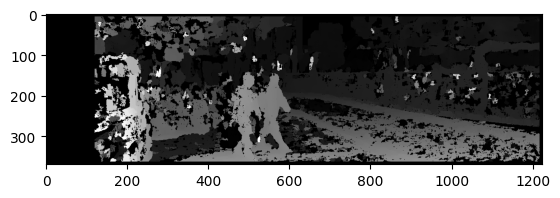

In [86]:
# Load the saved disparity map
dispMap = np.load("disparityMap.npy")

#Display the map
plt.imshow(dispMap, 'gray')

In [13]:
def export_pointcloud(disparity_map, colors, filename):

    def write_ply(fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        verts = verts.reshape(-1, 3)
        colors = colors.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
    
    
    h, w = disparity_map.shape[:2]
    f = .8 * w  # guess for focal length. If you 3D reconstruction looks skewed in the viewing direction, try adjusting this parameter.
    Q = np.float32([[ 1.00,  0.0,  0.0,  6.22731182e+03],
                  [ 0.0,  -1.00,  0.0, -3.36254675e+02],
                  [ 0.0,  0.0,   0.0, -5.78620767e+02],
                  [ 0.0,  0.0,  7.41532459e-04, 8.79243675e+00]]) # Obtained from stereo rectify
    
    # Q = np.float32([[1.,  0., 0. ,    -604.0814209 ],
    #                 [0., 1.,  0.,     -180.50661469],
    #                 [0., 0.,  0.,      707.04931641],
    #                 [0., 0., -1.85185185,   0.]]) # Obtained from P_rect_02 and _03 kitti variables
    
    # Q = np.float32([[1, 0, 0, -0.5 * w],
    #                 [0, -1, 0, 0.5 * h],  # turn points 180 deg around x-axis,
    #                 [0, 0, 0, -f],        # so that y-axis looks up
    #                 [0, 0, 1, 0]])        # FROM THE EXERCISES
    points = cv2.reprojectImageTo3D(disparity_map, Q)
    
    colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB)
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]

    write_ply(filename, out_points, out_colors)
    print(f'{filename} saved')

In [14]:
# Fetch the saved disparity map
recentDisp = dispMap.copy()
export_pointcloud(recentDisp, left_img, "pointcloud.ply")

pointcloud.ply saved
